## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets
import datasets
dataset = datasets.load_dataset('emotion') #https://huggingface.co/datasets/dair-ai/emotion
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']


In [5]:
def get_tweets(dataset):
    tweets = [x['text'] for x in dataset]
    labels = [x['label'] for x in dataset]
    return tweets, labels

In [6]:
train_tweets, train_labels = get_tweets(train)
val_tweets, val_labels = get_tweets(val)
test_tweets, test_labels = get_tweets(test)

In [7]:
train_tweets[0], train_labels[0]

('i didnt feel humiliated', 0)

In [8]:
# find the unique values in labels
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5])

## Task 4: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer  = Tokenizer(num_words=10000, oov_token='<UNK>') #out of vocabulary, unlikely...
tokenizer.fit_on_texts(train_tweets)

In [17]:
print(train_tweets[0])
tokenizer.texts_to_sequences(train_tweets[0])

i didnt feel humiliated


[[2],
 [],
 [669],
 [2],
 [669],
 [1726],
 [43],
 [],
 [1997],
 [1550],
 [1550],
 [8884],
 [],
 [6051],
 [966],
 [93],
 [2],
 [8884],
 [2],
 [7],
 [43],
 [1550],
 [669]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

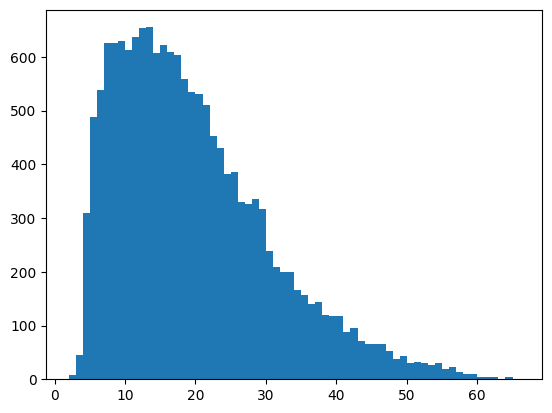

In [18]:
lengths = [len(t.split(' ')) for t in train_tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [19]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [20]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequences

In [21]:
padded_train_sequences = get_sequences(tokenizer, train_tweets)
padded_val_sequences = get_sequences(tokenizer, val_tweets)
padded_test_sequences = get_sequences(tokenizer, test_tweets)


In [22]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [23]:
classes = set(train_labels)
classes

{0, 1, 2, 3, 4, 5}

In [24]:
print(train_tweets[0],train_labels[0])

i didnt feel humiliated 0


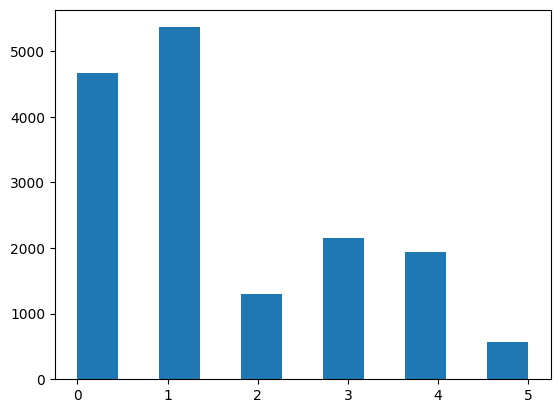

In [26]:
plt.hist(train_labels, bins=11)
plt.show()

In [27]:
classes_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_classes = dict((v,k) for k,v in classes_to_index.items())

In [28]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [29]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [30]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [31]:
train_labels = names_to_ids(train_labels)
val_labels = names_to_ids(val_labels)
test_labels = names_to_ids(test_labels)

In [32]:
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set